In [ ]:
pip install livelossplot


Mainly used this blog : https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/#:~:text=Fine%2DTuning%20Approach,-In%20this%20approach&text=The%20goal%20of%20fine%2Dtuning,outputting%20the%20transformed%20visual%20features.

In [ ]:
import os
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Flatten
import tensorflow as tf
from pathlib import Path
from livelossplot.inputs.keras import PlotLossesCallback
from sklearn.metrics import accuracy_score
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pathlib
training_data_path = pathlib.Path("/content/drive/MyDrive/DL_A2_transfer_learning/Dataset/train")

testing_data_path = pathlib.Path("/content/drive/MyDrive/DL_A2_transfer_learning/Dataset/test")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:


BATCH_SIZE = 200

train_generator = ImageDataGenerator(
    rotation_range=90,
    brightness_range=[0.1, 0.7],
    width_shift_range=0.5,
    height_shift_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0,
    preprocessing_function=preprocess_input,
)  # VGG16 preprocessing

test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)  # VGG16 preprocessing



In [ ]:
import pathlib
train_data_dir = pathlib.Path("/content/drive/MyDrive/DL_A2_transfer_learning/Dataset/train")

test_data_dir = pathlib.Path("/content/drive/MyDrive/DL_A2_transfer_learning/Dataset/test")



train_generator = ImageDataGenerator(
    rotation_range=90,
    brightness_range=[0.1, 0.7],
    width_shift_range=0.5,
    height_shift_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2,
    preprocessing_function=preprocess_input,
)  # VGG16 preprocessing

traingen = train_generator.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    class_mode="categorical",
    subset="training",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

validgen = train_generator.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    class_mode="categorical",
    subset="validation",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

testgen = test_generator.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    class_mode=None,
    batch_size=1,
    shuffle=False,
    seed=42,
)


Found 2800 images belonging to 5 classes.
Found 700 images belonging to 5 classes.
Found 700 images belonging to 5 classes.


In [ ]:

def create_model(input_shape, n_classes, optimizer="rmsprop", fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False, weights="imagenet", input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation="relu")(top_model)
    top_model = Dense(1072, activation="relu")(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation="softmax")(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model

In [ ]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes = 5

n_steps = traingen.samples // batch_size
n_val_steps = validgen.samples // batch_size
n_epochs = 5

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)


plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(
    filepath="drive/MyDrive/task_1/main_vgg.weights.best.keras", save_best_only=True, verbose=1
)

# EarlyStopping
early_stop = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, mode="min"
)



In [ ]:
print(vgg_model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 121,876,581 (464.92 MB)

 Trainable params: 107,161,893 (408.79 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


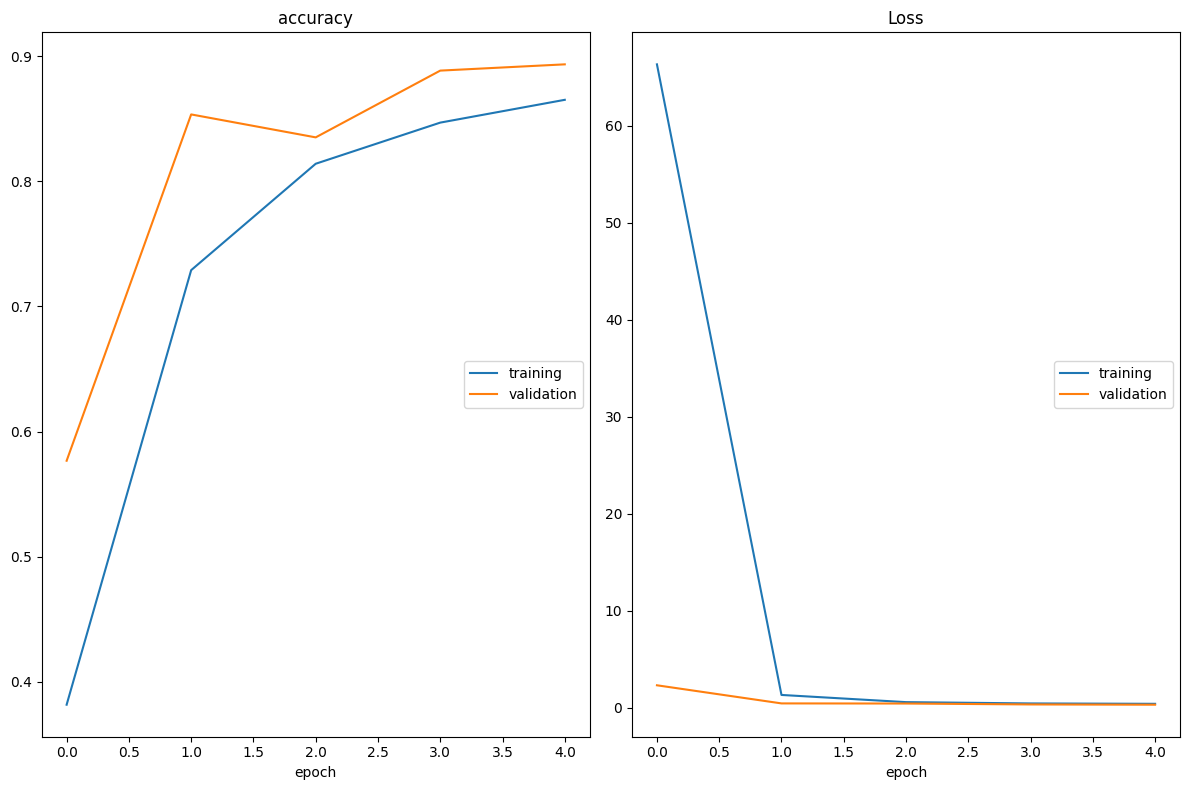

accuracy
	training         	 (min:    0.382, max:    0.865, cur:    0.865)
	validation       	 (min:    0.577, max:    0.893, cur:    0.893)
Loss
	training         	 (min:    0.408, max:   66.305, cur:    0.408)
	validation       	 (min:    0.316, max:    2.317, cur:    0.316)
14/14 ━━━━━━━━━━━━━━━━━━━━ 140s 6s/step - accuracy: 0.8639 - loss: 0.4127 - val_accuracy: 0.8933 - val_loss: 0.3163
CPU times: user 6min 14s, sys: 43.9 s, total: 6min 58s
Wall time: 26min 55s


In [ ]:
%%time


vgg_history = vgg_model.fit(
    traingen,
    batch_size=batch_size,
    epochs=n_epochs,
    validation_data=validgen,
    steps_per_epoch=n_steps,
    validation_steps=n_val_steps,
    callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
    verbose=1,
)

In [ ]:
# Generate predictions
vgg_model.load_weights('drive/MyDrive/task_1/main_vgg.weights.best.keras') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

700/700 ━━━━━━━━━━━━━━━━━━━━ 325s 462ms/step


In [ ]:
print(vgg_pred_classes)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 4 0 0 0 1 0 3 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 2 2 0 0 0 0 0 0 0 0 3 0 0 4 1 0 3 0 0 0 0 0
 0 0 2 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1
 2 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 4
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 1 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 

In [ ]:
vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 95.14%


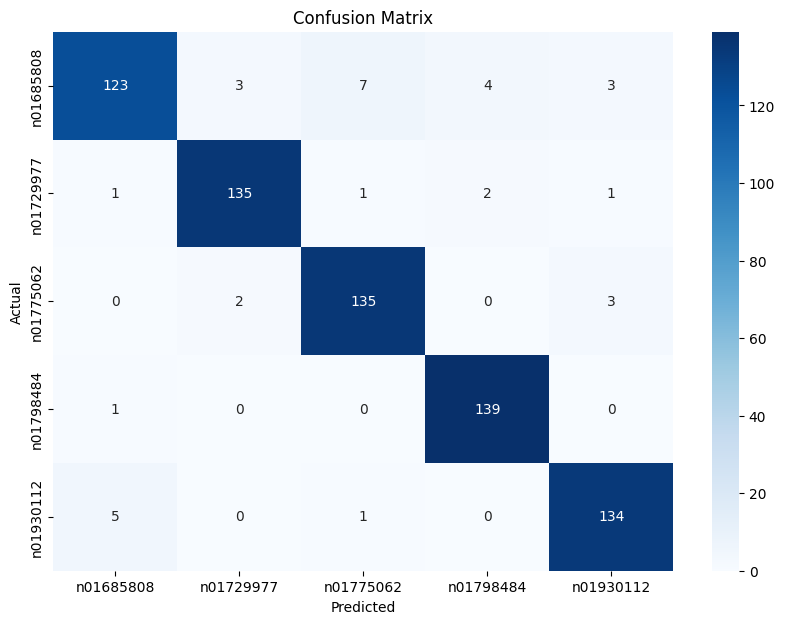

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
# Compute the confusion matrix
cm = confusion_matrix(true_classes, vgg_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_indices.values(), yticklabels=class_indices.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Using finetuning


In [ ]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()

# Use a smaller learning rate
optim_2 = Adam(learning_rate=0.01)
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(
    filepath="drive/MyDrive/task_1/main_vgg_ft.weights.best.keras", save_best_only=True, verbose=1
)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

In [ ]:
print(len(validgen))

4


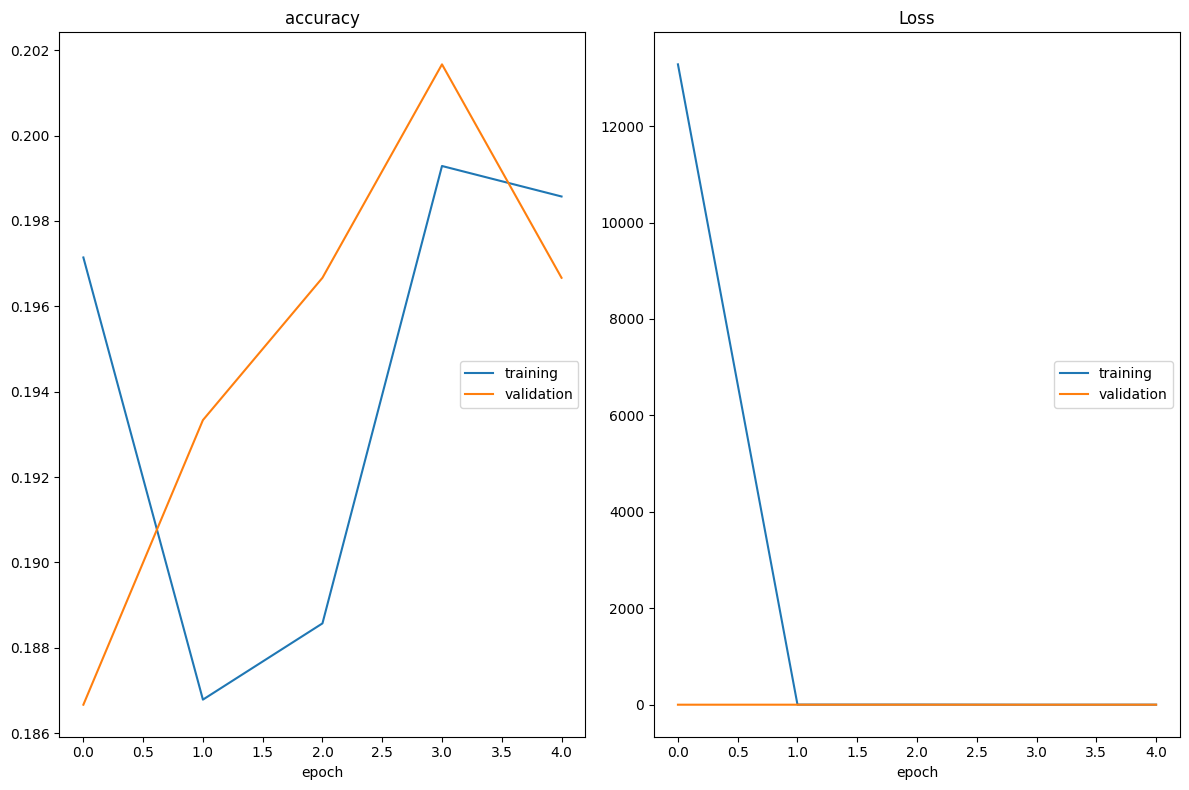

accuracy
	training         	 (min:    0.187, max:    0.199, cur:    0.199)
	validation       	 (min:    0.187, max:    0.202, cur:    0.197)
Loss
	training         	 (min:    1.610, max: 13279.549, cur:    2.151)
	validation       	 (min:    1.609, max:    1.815, cur:    1.815)
14/14 ━━━━━━━━━━━━━━━━━━━━ 93s 5s/step - accuracy: 0.2087 - loss: 1.8429 - val_accuracy: 0.1967 - val_loss: 1.8146
CPU times: user 5min 33s, sys: 31.6 s, total: 6min 5s
Wall time: 9min 10s


In [ ]:
%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=batch_size,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps,
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

In [ ]:
# prompt: print train_loss and val_loss

print(vgg_history.history['loss'])
print(vgg_history.history['val_loss'])
print(vgg_ft_history.history['loss'])
print(vgg_ft_history.history['val_loss'])


[66.30519104003906, 1.3219785690307617, 0.5810968279838562, 0.4463917016983032, 0.4082438051700592]
[2.317120313644409, 0.44983190298080444, 0.43744999170303345, 0.3428269326686859, 0.31627464294433594]
[13279.548828125, 3.452941656112671, 4.359947681427002, 1.6095325946807861, 2.1510469913482666]
[1.6110951900482178, 1.7509613037109375, 1.6094427108764648, 1.6096359491348267, 1.8146065473556519]


In [ ]:
# Generate predictions
vgg_model_ft.load_weights('drive/MyDrive/task_1/main_vgg_ft.weights.best.keras') # initialize the best trained weights

vgg_preds_ft = vgg_model_ft.predict(testgen)
vgg_pred_classes_ft = np.argmax(vgg_preds_ft, axis=1)

700/700 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step


In [ ]:
true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_acc_ft = accuracy_score(true_classes, vgg_pred_classes_ft)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(vgg_acc_ft * 100))

VGG16 Model Accuracy with Fine-Tuning: 20.00%


In [ ]:
print(vgg_model_ft.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 340,919,985 (1.27 GB)

 Trainable params: 109,521,701 (417.79 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

 Optimizer params: 219,043,404 (835.58 MB)

None
